## Analysis Final for BMI520

Proof of concept of the Database and its potential uses downstream for analyses.

Connecting to the google SQL server is shamelessly ripped from this [Link](https://colab.research.google.com/github/GoogleCloudPlatform/cloud-sql-python-connector/blob/main/samples/notebooks/mysql_python_connector.ipynb#scrollTo=UzHaM-6TXO8h)

Thanks @MattObusan for finding the link because I could not figure this out by myself.

In [12]:
!pip install "cloud-sql-python-connector[pymysql]"
!pip install "gcloud"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.4/454.4 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gcloud: filename=gcloud-0.18.3-py3-none-any.whl size=602928 sha256=9b35c6c9b3134d1ea15287fdc0658bc206e96f9b4c61061582eb6108ea17eb3d
  Stored in directory: /root/.cache/pip/wheels/7c/30/88/5017af921da3a33af785f0d0fd3e944b845bc62a445a2c2f69
Successfully built gcloud


In [ ]:
!gcloud auth login
!gcloud config set project [YOUR PROJECT ID]
!gcloud sql instances describe [YOUR CLOUDSQL INSTANCE ID]

In [36]:
from google.cloud.sql.connector import Connector
import sqlalchemy as sa
import pymysql
import pandas as pd

In [19]:
from google.colab import auth

auth.authenticate_user()

In [20]:
!gcloud config set project bmi520nbastatssql

Updated property [core/project].


In [22]:
current_user = !gcloud auth list --filter=status:ACTIVE --format="value(account)"

!gcloud projects add-iam-policy-binding bmi520nbastatssql \
  --member=user:{current_user[0]} \
  --role="roles/cloudsql.client"

Updated IAM policy for project [bmi520nbastatssql].
bindings:
- members:
  - serviceAccount:quickstart-service-account@bmi520nbastatssql.iam.gserviceaccount.com
  - user:Max.Longhao.Chao@gmail.com
  role: roles/cloudsql.client
- members:
  - serviceAccount:service-641611893501@compute-system.iam.gserviceaccount.com
  role: roles/compute.serviceAgent
- members:
  - serviceAccount:service-641611893501@gcp-sa-datamigration.iam.gserviceaccount.com
  role: roles/datamigration.serviceAgent
- members:
  - serviceAccount:641611893501-compute@developer.gserviceaccount.com
  - serviceAccount:641611893501@cloudservices.gserviceaccount.com
  role: roles/editor
- members:
  - user:Max.Longhao.Chao@gmail.com
  role: roles/owner
etag: BwYXLaWJcwQ=
version: 1


In [23]:
!gcloud services enable sqladmin.googleapis.com

In [24]:
region = "us-central1"
instance_name = "nbastatsscrape"
database_version = !gcloud sql instances describe {instance_name} --format="value(databaseVersion)"
if database_version[0].startswith("MYSQL"):
  print("Found existing MySQL Cloud SQL Instance!")
else:
  print("Creating new Cloud SQL instance...")
  password = input("Please provide a password to be used for database 'root' user: ")
  !gcloud sql instances create {instance_name} --database-version=MYSQL_8_0 \
    --region={region} --cpu=1 --memory=4GB --root-password={password} \
    --database-flags=cloudsql_iam_authentication=On

Found existing MySQL Cloud SQL Instance!


In [25]:
!gcloud sql databases create sandwiches --instance={instance_name}

Created database [sandwiches].
instance: nbastatsscrape
name: sandwiches
project: bmi520nbastatssql


In [26]:
!gcloud sql users create chef \
  --instance={instance_name} \
  --password="no"

Created user [chef].


In [27]:
from google.colab import auth

auth.authenticate_user()
# install dependencies
import sys
!{sys.executable} -m pip install cloud-sql-python-connector["pymysql"] SQLAlchemy==2.0.7

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 10.0 MB/s eta 0:00:00
  Attempting uninstall: SQLAlchemy
    Found existing installation: SQLAlchemy 2.0.29
    Uninstalling SQLAlchemy-2.0.29:
      Successfully uninstalled SQLAlchemy-2.0.29


In [38]:
# initialize parameters
INSTANCE_CONNECTION_NAME = f"bmi520nbastatssql:us-central1:nbastatsscrape" # i.e demo-project:us-central1:demo-instance
print(f"Your instance connection name is: {INSTANCE_CONNECTION_NAME}")
DB_USER = "chef"
DB_PASS = "no"
DB_NAME = "NBAPlayerStats2023_24"

Your instance connection name is: bmi520nbastatssql:us-central1:nbastatsscrape


In [39]:
from google.cloud.sql.connector import Connector
import sqlalchemy

# initialize Connector object
connector = Connector()

# function to return the database connection object
def getconn():
    conn = connector.connect(
        INSTANCE_CONNECTION_NAME,
        "pymysql",
        user=DB_USER,
        password=DB_PASS,
        db=DB_NAME
    )
    return conn

# create connection pool with 'creator' argument to our connection object function
pool = sqlalchemy.create_engine(
    "mysql+pymysql://",
    creator=getconn,
)




In [40]:
connection = pool.connect()

In [106]:
q = """SHOW TABLES"""
t=pd.read_sql(sa.text(q), connection)
t

,Tables_in_NBAPlayerStats2023_24
0,advanced
1,defense
2,est_advanced
3,misc
4,opponent
5,player_usage
6,players
7,scoring
8,traditional
9,usage


In [117]:
for i in t['Tables_in_NBAPlayerStats2023_24'][:-1]:
  q="SHOW COLUMNS FROM " + i
  print(i)
  print(pd.read_sql(sa.text(q), connection))
#done

advanced
        Field    Type Null Key Default Extra
0          ID  bigint  YES        None      
1      PLAYER    text  YES        None      
2        TEAM    text  YES        None      
3         AGE  bigint  YES        None      
4          GP  bigint  YES        None      
5           W  bigint  YES        None      
6           L  bigint  YES        None      
7         MIN  double  YES        None      
8      OFFRTG  double  YES        None      
9      DEFRTG  double  YES        None      
10     NETRTG  double  YES        None      
11       ASTP  double  YES        None      
12     AST_TO  double  YES        None      
13  AST_RATIO  double  YES        None      
14      OREBP  double  YES        None      
15      DREBP  double  YES        None      
16       REBP  double  YES        None      
17   TO_RATIO  double  YES        None      
18       EFGP  double  YES        None      
19        TSP  double  YES        None      
20       USGP  double  YES        None      
2

In [73]:
q = """SELECT * FROM players LIMIT 10"""
pd.read_sql(sa.text(q), connection)

,ID,PLAYER,TEAM,AGE,HEIGHT,WEIGHT
0,1,A.J. Lawson,DAL,23,198.12,179
1,2,AJ Green,MIL,24,193.04,190
2,3,AJ Griffin,ATL,20,198.12,220
3,4,Aaron Gordon,DEN,28,203.20,235
4,5,Aaron Holiday,HOU,27,182.88,185
5,6,Aaron Nesmith,IND,24,198.12,215
6,7,Aaron Wiggins,OKC,25,195.58,190
7,8,Adam Flagler,OKC,24,190.50,180
8,9,Adama Sanogo,CHI,22,205.74,245
9,10,Admiral Schofield,ORL,26,195.58,241


In [53]:
q = """SELECT * FROM traditional LIMIT 10"""
pd.read_sql(sa.text(q), connection)

,ID,PLAYER,TEAM,AGE,GP,W,L,MIN,PTS,FGM,...,REB,AST,TOV,STL,BLK,PF,FP,DD2,TD3,plus_minus
0,1,A.J. Lawson,DAL,23,30,17,13,7.9,3.6,1.4,...,1.1,0.4,0.3,0.3,0.1,0.6,6.5,0.0,0.0,0.9
1,2,AJ Green,MIL,24,42,29,13,9.6,4.3,1.5,...,1.1,0.6,0.2,0.1,0.0,0.9,6.7,0.0,0.0,0.2
2,3,AJ Griffin,ATL,20,18,8,10,7.4,2.1,0.7,...,0.8,0.2,0.3,0.1,0.1,0.3,3.3,0.0,0.0,-1.6
3,4,Aaron Gordon,DEN,28,58,39,19,31.4,13.8,5.5,...,6.5,3.2,1.5,0.9,0.6,1.9,29.4,10.0,0.0,5.6
4,5,Aaron Holiday,HOU,27,61,28,33,16.5,6.6,2.4,...,1.7,1.8,0.7,0.5,0.1,1.5,12.3,0.0,0.0,0.9
5,6,Aaron Nesmith,IND,24,56,31,25,27.1,12.3,4.4,...,3.8,1.4,0.9,1.0,0.7,3.3,23.1,1.0,0.0,1.3
6,7,Aaron Wiggins,OKC,25,61,44,17,14.6,6.2,2.4,...,2.3,0.9,0.6,0.6,0.2,1.1,12.1,0.0,0.0,0.7
7,8,Adam Flagler,OKC,24,1,1,0,5.5,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.5,0.0,0.0,0.0
8,9,Adama Sanogo,CHI,22,3,0,3,3.5,2.7,1.0,...,2.0,0.0,0.3,0.0,0.0,0.0,4.7,0.0,0.0,5.7
9,10,Admiral Schofield,ORL,26,16,9,7,3.5,0.9,0.4,...,0.6,0.3,0.3,0.0,0.0,0.4,1.9,0.0,0.0,0.6


In [90]:
q = """SELECT DISTINCT p.AGE, p.HEIGHT, p.WEIGHT, t.PTS, t.PLAYER, t.ID FROM traditional t
       JOIN players p on t.id = p.id"""
trad_stats = pd.read_sql(sa.text(q), connection)
# basic grab joining player with traditional

In [91]:
trad_stats

,AGE,HEIGHT,WEIGHT,PTS,PLAYER,ID
0,23,198.12,179,3.6,A.J. Lawson,1
1,24,193.04,190,4.3,AJ Green,2
2,20,198.12,220,2.1,AJ Griffin,3
3,28,203.20,235,13.8,Aaron Gordon,4
4,27,182.88,185,6.6,Aaron Holiday,5
...,...,...,...,...,...,...
549,26,210.82,250,11.4,Zach Collins,550
550,29,195.58,200,19.5,Zach LaVine,551
551,23,205.74,240,3.2,Zeke Nnaji,552
552,22,205.74,185,8.2,Ziaire Williams,553


Age of 554 Players in the NBA 23/24 Season


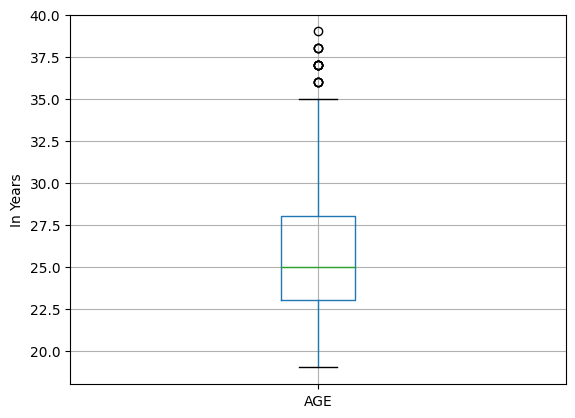

In [96]:
import matplotlib.pyplot as plt
#grab basic information about age height and weight.
trad_stats[['AGE']].boxplot()
plt.title(print('Age of ' + str(trad_stats.shape[0])+' Players in the NBA 23/24 Season'))
plt.ylabel('In Years')
plt.show()
# box plots

Height of 554 Players in the NBA 23/24 Season


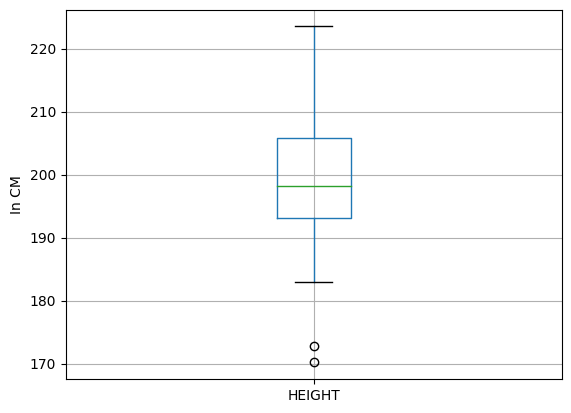

In [98]:
trad_stats[['HEIGHT']].boxplot()
plt.title(print('Height of ' + str(trad_stats.shape[0])+' Players in the NBA 23/24 Season'))
plt.ylabel('In CM')
plt.show()

WEIGHT of 554 Players in the NBA 23/24 Season


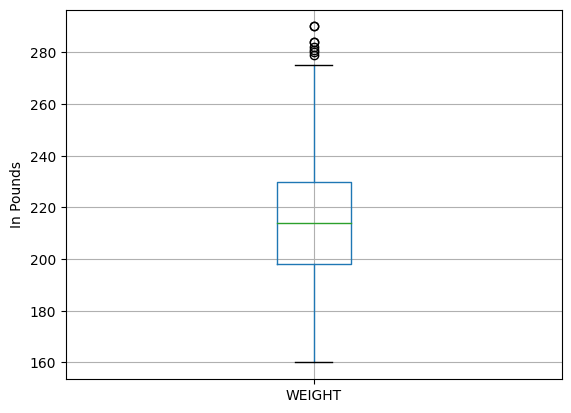

In [99]:
trad_stats[['WEIGHT']].boxplot()
plt.title(print('WEIGHT of ' + str(trad_stats.shape[0])+' Players in the NBA 23/24 Season'))
plt.ylabel('In Pounds')
plt.show()

In [122]:
trad_stats[['AGE', 'HEIGHT','WEIGHT']].describe()

,AGE,HEIGHT,WEIGHT
count,554.000000,554.000000,554.000000
mean,25.866426,199.188267,214.810469
std,4.250756,8.000900,23.753979
min,19.000000,170.180000,160.000000
25%,23.000000,193.040000,198.000000
50%,25.000000,198.120000,214.000000
75%,28.000000,205.740000,230.000000
max,39.000000,223.520000,290.000000


## Correlation Plots


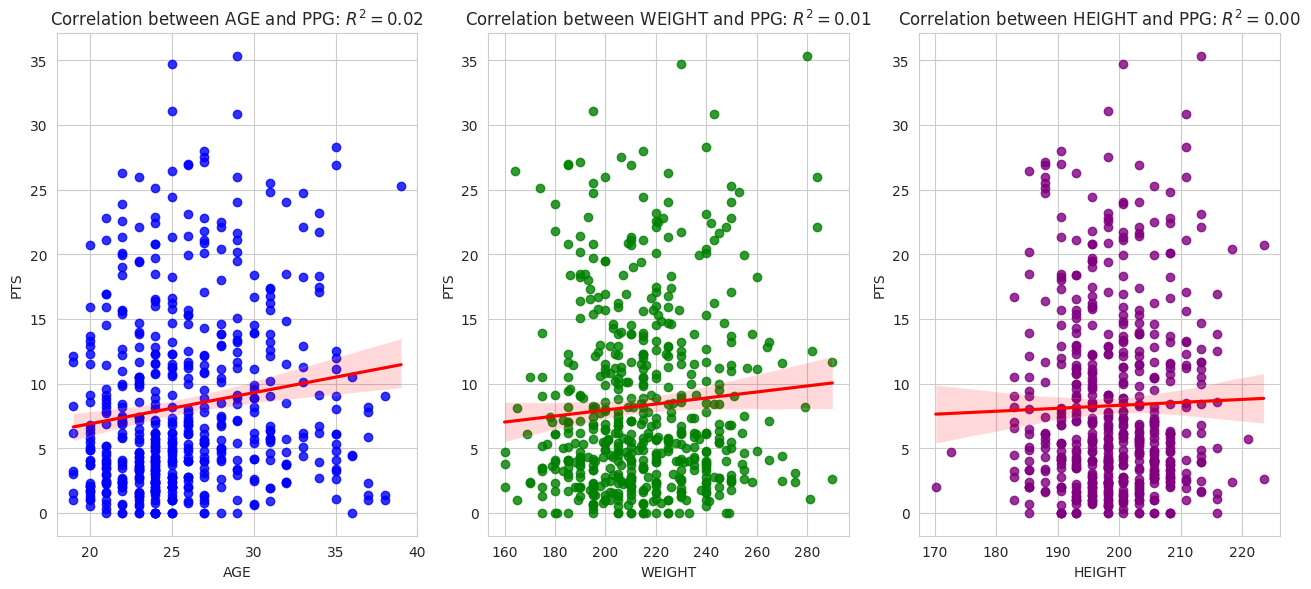

In [140]:
# how to these 3 physiological features correlate to PPG?
import seaborn as sns
import scipy as sp

import statsmodels.api as sm
# include R2
def calculate_r_squared(df, x_col, y_col):
    """Calculate R-squared for columns x_col and y_col in dataframe df."""
    X = df[x_col]
    X = sm.add_constant(X)  # adding a constant for the intercept
    Y = df[y_col]

    model = sm.OLS(Y, X).fit()
    return model.rsquared

# get R2 for all three:
ager =calculate_r_squared(trad_stats, 'AGE', 'PTS')
wr =calculate_r_squared(trad_stats, 'WEIGHT', 'PTS')
hr =calculate_r_squared(trad_stats, 'HEIGHT', 'PTS')
sns.set_style("whitegrid")

# Create a figure with subplots
plt.figure(figsize=(13, 6))

# Plot for Column1 vs Column3
plt.subplot(1, 3, 1)  # 1 row, 2 columns, 1st subplot
sns.regplot(x='AGE', y='PTS', data=trad_stats, scatter_kws={"color": "blue"}, line_kws={"color": "red"})
plt.title(f'Correlation between AGE and PPG: $R^2={ager:.2f}$')

# Plot for Column2 vs Column3
plt.subplot(1, 3, 2)  # 1 row, 2 columns, 2nd subplot
sns.regplot(x='WEIGHT', y='PTS', data=trad_stats, scatter_kws={"color": "green"}, line_kws={"color": "red"})
plt.title(f'Correlation between WEIGHT and PPG: $R^2={wr:.2f}$')

# Plot for Column2 vs Column3
plt.subplot(1, 3, 3)  # 1 row, 2 columns, 2nd subplot
sns.regplot(x='HEIGHT', y='PTS', data=trad_stats, scatter_kws={"color": "purple"}, line_kws={"color": "red"})
plt.title(f'Correlation between HEIGHT and PPG: $R^2={hr:.2f}$')

# Display the plots
plt.tight_layout()
plt.show()

In [132]:
# sort by ppg
trad_stats.sort_values(by='PTS', ascending=False)

,AGE,HEIGHT,WEIGHT,PTS,PLAYER,ID
273,29,213.36,280,35.3,Joel Embiid,274
361,25,200.66,230,34.7,Luka Doncic,362
486,25,198.12,195,31.1,Shai Gilgeous-Alexander,487
179,29,210.82,243,30.8,Giannis Antetokounmpo,180
327,35,210.82,240,28.3,Kevin Durant,328
...,...,...,...,...,...,...
252,24,193.04,205,0.0,Javonte Smart,253
250,24,190.50,181,0.0,Jason Preston,251
471,29,190.50,195,0.0,Ryan Arcidiacono,472
225,24,185.42,175,0.0,Jalen Crutcher,226


In [135]:
# now lets take players who actually get real minutes a game
q = """SELECT DISTINCT p.AGE, p.HEIGHT, p.WEIGHT, t.PTS, t.PLAYER, t.ID, t.MIN FROM traditional t
       JOIN players p on t.id = p.id WHERE MIN > 15"""
trad_stats_min = pd.read_sql(sa.text(q), connection)

In [136]:
# filter for players more than 15 minutes
trad_stats_min

,AGE,HEIGHT,WEIGHT,PTS,PLAYER,ID,MIN
0,28,203.20,235,13.8,Aaron Gordon,4,31.4
1,27,182.88,185,6.6,Aaron Holiday,5,16.5
2,24,198.12,215,12.3,Aaron Nesmith,6,27.1
3,37,205.74,240,7.8,Al Horford,11,26.7
4,32,195.58,214,11.5,Alec Burks,12,19.7
...,...,...,...,...,...,...,...
306,25,200.66,245,5.8,Xavier Tillman,548,19.7
307,26,210.82,250,11.4,Zach Collins,550,23.3
308,29,195.58,200,19.5,Zach LaVine,551,34.9
309,22,205.74,185,8.2,Ziaire Williams,553,20.3


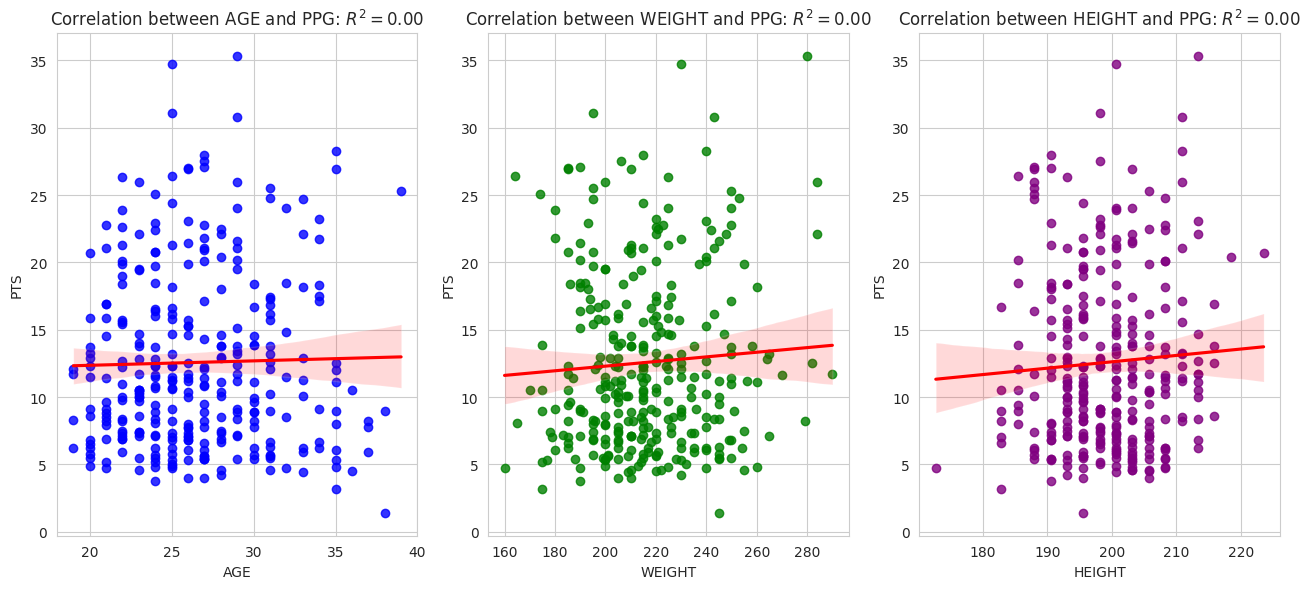

In [141]:
# include R2
def calculate_r_squared(df, x_col, y_col):
    """Calculate R-squared for columns x_col and y_col in dataframe df."""
    X = df[x_col]
    X = sm.add_constant(X)  # adding a constant for the intercept
    Y = df[y_col]

    model = sm.OLS(Y, X).fit()
    return model.rsquared

# get R2 for all three:
ager =calculate_r_squared(trad_stats_min, 'AGE', 'PTS')
wr =calculate_r_squared(trad_stats_min, 'WEIGHT', 'PTS')
hr =calculate_r_squared(trad_stats_min, 'HEIGHT', 'PTS')
sns.set_style("whitegrid")

# Create a figure with subplots
plt.figure(figsize=(13, 6))

# Plot for Column1 vs Column3
plt.subplot(1, 3, 1)  # 1 row, 2 columns, 1st subplot
sns.regplot(x='AGE', y='PTS', data=trad_stats_min, scatter_kws={"color": "blue"}, line_kws={"color": "red"})
plt.title(f'Correlation between AGE and PPG: $R^2={ager:.2f}$')

# Plot for Column2 vs Column3
plt.subplot(1, 3, 2)  # 1 row, 2 columns, 2nd subplot
sns.regplot(x='WEIGHT', y='PTS', data=trad_stats_min, scatter_kws={"color": "green"}, line_kws={"color": "red"})
plt.title(f'Correlation between WEIGHT and PPG: $R^2={wr:.2f}$')

# Plot for Column2 vs Column3
plt.subplot(1, 3, 3)  # 1 row, 2 columns, 2nd subplot
sns.regplot(x='HEIGHT', y='PTS', data=trad_stats_min, scatter_kws={"color": "purple"}, line_kws={"color": "red"})
plt.title(f'Correlation between HEIGHT and PPG: $R^2={hr:.2f}$')

# Display the plots
plt.tight_layout()
plt.show()

In [157]:
import numpy as np
# linear regresssion of stats on PPG
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Define the independent and dependent variables
X = trad_stats_min[['AGE', 'HEIGHT', 'WEIGHT']]  # independent variables
y = trad_stats_min['PTS']  # dependent variable

# create split
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                   random_state=104,
                                   test_size=0.2,
                                   shuffle=True)


# Create a linear regression model instance
model = LinearRegression()

# Fit the model
model.fit(X, y)

# Display the coefficients
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

# Use the model to make predictions
y_pred = model.predict(X)

Coefficients: [0.03029436 0.02871136 0.00942682]
Intercept: 4.013763128728835


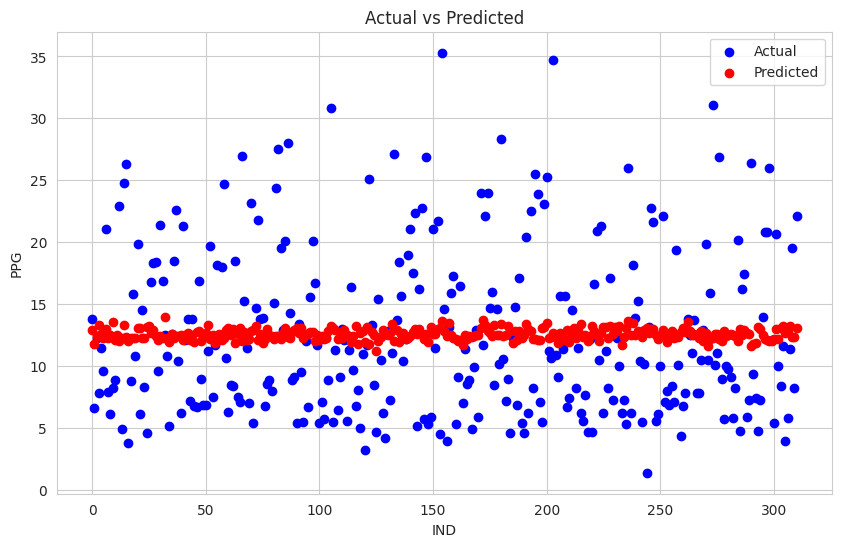

In [159]:
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y)), y, color='blue', label='Actual')
plt.scatter(range(len(y)), y_pred, color='red', label='Predicted')
plt.title('Actual vs Predicted')
plt.xlabel('IND')
plt.ylabel('PPG')
plt.legend()
plt.show()

In [161]:
len(y)

311

## Looking into Player Efficiency


Looking at True shooting percentage: how well a player shoots per shot attempt

In [182]:
# now lets take players who actually get real minutes a game
# and player efficiency stats: Want TSP and USGP
q = """SELECT DISTINCT p.AGE, p.HEIGHT, p.WEIGHT, a.TSP, a.USGP, a.EFGP, a.ID, a.MIN FROM advanced a
       JOIN players p on a.id = p.id WHERE MIN > 15"""
advanced_stat_min = pd.read_sql(sa.text(q), connection)

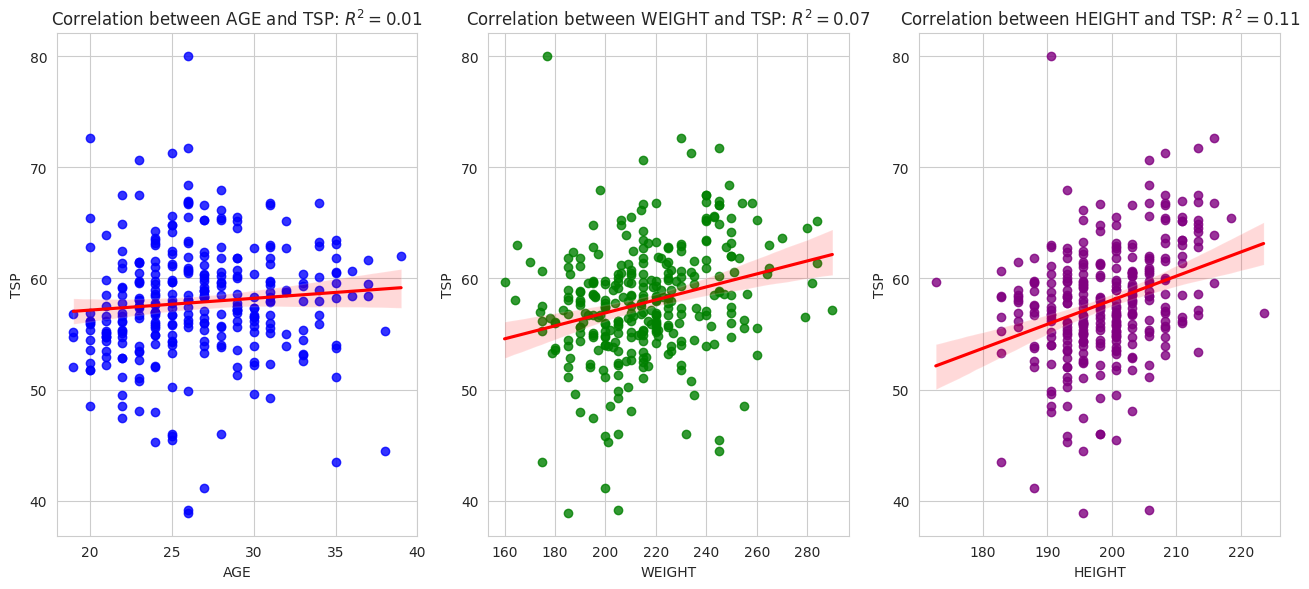

In [183]:
# include R2
def calculate_r_squared(df, x_col, y_col):
    """Calculate R-squared for columns x_col and y_col in dataframe df."""
    X = df[x_col]
    X = sm.add_constant(X)  # adding a constant for the intercept
    Y = df[y_col]

    model = sm.OLS(Y, X).fit()
    return model.rsquared

# get R2 for all three:
ager =calculate_r_squared(advanced_stat_min, 'AGE', 'TSP')
wr =calculate_r_squared(advanced_stat_min, 'WEIGHT', 'TSP')
hr =calculate_r_squared(advanced_stat_min, 'HEIGHT', 'TSP')
sns.set_style("whitegrid")

# Create a figure with subplots
plt.figure(figsize=(13, 6))

# Plot for Column1 vs Column3
plt.subplot(1, 3, 1)  # 1 row, 2 columns, 1st subplot
sns.regplot(x='AGE', y='TSP', data=advanced_stat_min, scatter_kws={"color": "blue"}, line_kws={"color": "red"})
plt.title(f'Correlation between AGE and TSP: $R^2={ager:.2f}$')

# Plot for Column2 vs Column3
plt.subplot(1, 3, 2)  # 1 row, 2 columns, 2nd subplot
sns.regplot(x='WEIGHT', y='TSP', data=advanced_stat_min, scatter_kws={"color": "green"}, line_kws={"color": "red"})
plt.title(f'Correlation between WEIGHT and TSP: $R^2={wr:.2f}$')

# Plot for Column2 vs Column3
plt.subplot(1, 3, 3)  # 1 row, 2 columns, 2nd subplot
sns.regplot(x='HEIGHT', y='TSP', data=advanced_stat_min, scatter_kws={"color": "purple"}, line_kws={"color": "red"})
plt.title(f'Correlation between HEIGHT and TSP: $R^2={hr:.2f}$')

# Display the plots
plt.tight_layout()
plt.show()

In [184]:
# Define the independent and dependent variables
X = advanced_stat_min[['AGE', 'HEIGHT', 'WEIGHT']]  # independent variables
y = advanced_stat_min['TSP']  # dependent variable

# create split
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                   random_state=104,
                                   test_size=0.2,
                                   shuffle=True)


# Create a linear regression model instance
model = LinearRegression()

# Fit the model
model.fit(X, y)

# Display the coefficients
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

# Use the model to make predictions
y_pred = model.predict(X)

Coefficients: [0.14173686 0.22211302 0.00076942]
Intercept: 9.694422608392479


In [185]:
from sklearn.metrics import mean_squared_error, r2_score

# Calculate MSE
mse = mean_squared_error(y, y_pred)
print("Mean Squared Error (MSE):", mse)

# Calculate RMSE
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)


# Calculate R-squared (R^2)
r2 = r2_score(y, y_pred)
print("R-squared (R^2):", r2)

Mean Squared Error (MSE): 24.385834320148867
Root Mean Squared Error (RMSE): 4.938201526886976
R-squared (R^2): 0.12040840958919907


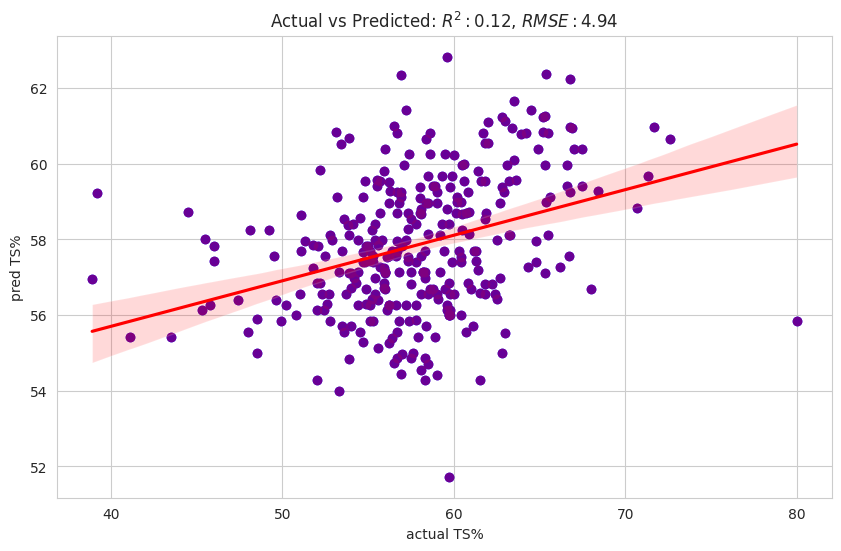

In [188]:
#goodness of fit of predicted vs actual
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, color='blue')
sns.regplot(x=y, y=y_pred, scatter_kws={"color": "purple"}, line_kws={"color": "red"})
plt.title(f'Actual vs Predicted: $R^2:{r2:.2f}$, $RMSE: {rmse:.2f}$')
plt.xlabel('actual TS%')
plt.ylabel('pred TS%')
plt.show()


### EFGP
stats

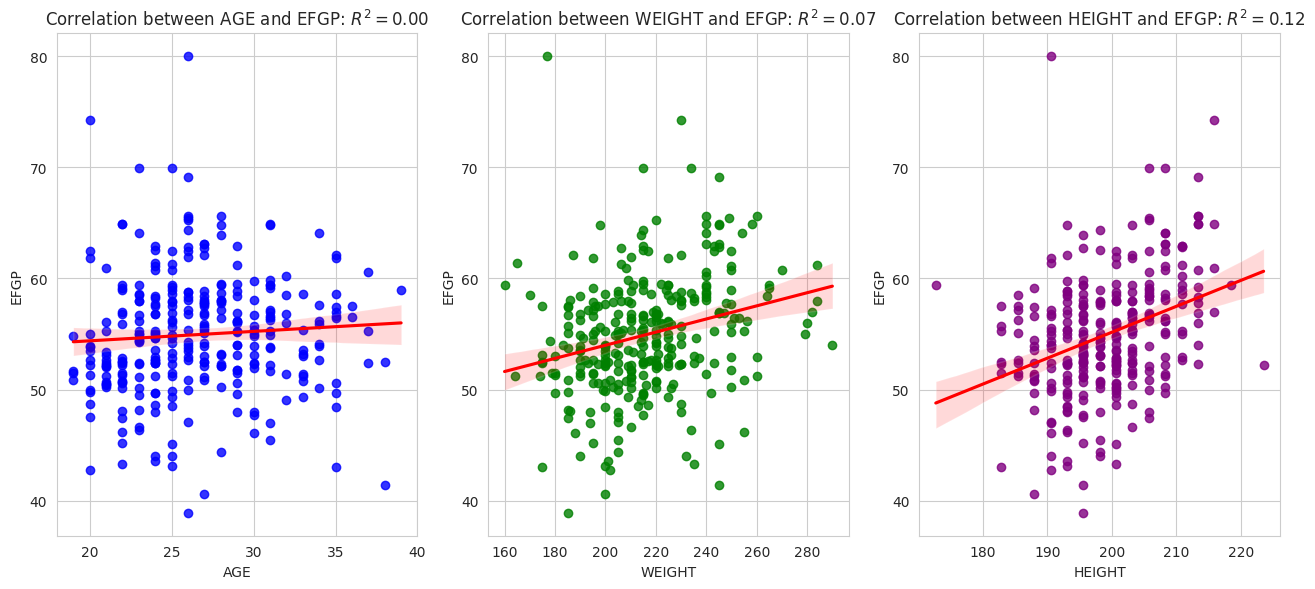

In [189]:
# include R2
def calculate_r_squared(df, x_col, y_col):
    """Calculate R-squared for columns x_col and y_col in dataframe df."""
    X = df[x_col]
    X = sm.add_constant(X)  # adding a constant for the intercept
    Y = df[y_col]

    model = sm.OLS(Y, X).fit()
    return model.rsquared

# get R2 for all three:
ager =calculate_r_squared(advanced_stat_min, 'AGE', 'EFGP')
wr =calculate_r_squared(advanced_stat_min, 'WEIGHT', 'EFGP')
hr =calculate_r_squared(advanced_stat_min, 'HEIGHT', 'EFGP')
sns.set_style("whitegrid")

# Create a figure with subplots
plt.figure(figsize=(13, 6))

# Plot for Column1 vs Column3
plt.subplot(1, 3, 1)  # 1 row, 2 columns, 1st subplot
sns.regplot(x='AGE', y='EFGP', data=advanced_stat_min, scatter_kws={"color": "blue"}, line_kws={"color": "red"})
plt.title(f'Correlation between AGE and EFGP: $R^2={ager:.2f}$')

# Plot for Column2 vs Column3
plt.subplot(1, 3, 2)  # 1 row, 2 columns, 2nd subplot
sns.regplot(x='WEIGHT', y='EFGP', data=advanced_stat_min, scatter_kws={"color": "green"}, line_kws={"color": "red"})
plt.title(f'Correlation between WEIGHT and EFGP: $R^2={wr:.2f}$')

# Plot for Column2 vs Column3
plt.subplot(1, 3, 3)  # 1 row, 2 columns, 2nd subplot
sns.regplot(x='HEIGHT', y='EFGP', data=advanced_stat_min, scatter_kws={"color": "purple"}, line_kws={"color": "red"})
plt.title(f'Correlation between HEIGHT and EFGP: $R^2={hr:.2f}$')

# Display the plots
plt.tight_layout()
plt.show()

In [190]:
# Define the independent and dependent variables
X = advanced_stat_min[['AGE', 'HEIGHT', 'WEIGHT']]  # independent variables
y = advanced_stat_min['EFGP']  # dependent variable

# create split
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                   random_state=104,
                                   test_size=0.2,
                                   shuffle=True)


# Create a linear regression model instance
model = LinearRegression()

# Fit the model
model.fit(X, y)

# Display the coefficients
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

# Use the model to make predictions
y_pred = model.predict(X)

Coefficients: [ 0.12964694  0.25082111 -0.00517487]
Intercept: 2.682527213502837


In [191]:
# Calculate MSE
mse = mean_squared_error(y, y_pred)
print("Mean Squared Error (MSE):", mse)

# Calculate RMSE
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)


# Calculate R-squared (R^2)
r2 = r2_score(y, y_pred)
print("R-squared (R^2):", r2)

Mean Squared Error (MSE): 25.45104216415517
Root Mean Squared Error (RMSE): 5.044902592137451
R-squared (R^2): 0.12753895595521492


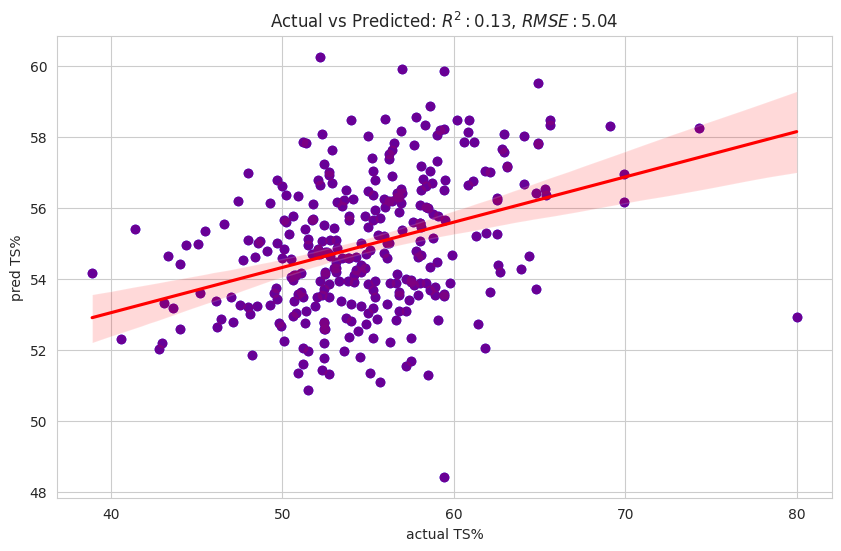

In [192]:
#goodness of fit of predicted vs actual
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, color='blue')
sns.regplot(x=y, y=y_pred, scatter_kws={"color": "purple"}, line_kws={"color": "red"})
plt.title(f'Actual vs Predicted: $R^2:{r2:.2f}$, $RMSE: {rmse:.2f}$')
plt.xlabel('actual EFG%')
plt.ylabel('pred EFG%')
plt.show()

# Block Percentage


Should be a height correlated event as typically centers lead a teams blk%
Just a final cute analysis to show off.

In [196]:
# now lets take players who actually get real minutes a game
# and player defense: Want BLK and BLK_PCT
q = """SELECT DISTINCT p.AGE, p.HEIGHT, p.WEIGHT, d.BLK, d.BLK_PCT, d.ID, d.PLAYER, d.MIN FROM defense d
       JOIN players p on d.id = p.id WHERE MIN > 15 & BLK > 0.5"""
def_stat_min = pd.read_sql(sa.text(q), connection)

In [197]:
def_stat_min

,AGE,HEIGHT,WEIGHT,BLK,BLK_PCT,ID,PLAYER,MIN
0,23,198.12,179,0.1,11.1,1,A.J. Lawson,7.9
1,24,193.04,190,0.0,6.5,2,AJ Green,9.6
2,20,198.12,220,0.1,7.7,3,AJ Griffin,7.4
3,28,203.20,235,0.6,19.7,4,Aaron Gordon,31.4
4,27,182.88,185,0.1,5.4,5,Aaron Holiday,16.5
...,...,...,...,...,...,...,...,...
549,26,210.82,250,0.7,31.9,550,Zach Collins,23.3
550,29,195.58,200,0.3,10.3,551,Zach LaVine,34.9
551,23,205.74,240,0.7,37.1,552,Zeke Nnaji,9.8
552,22,205.74,185,0.2,7.2,553,Ziaire Williams,20.3


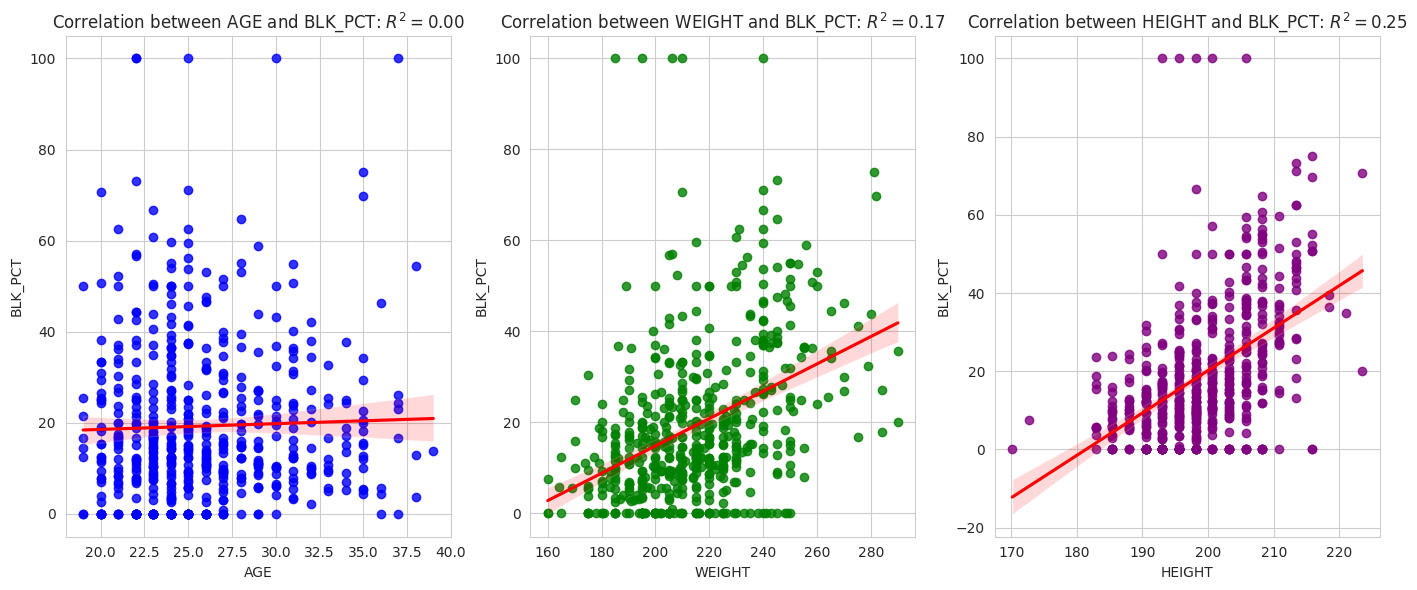

In [201]:
# get R2 for all three:
ager =calculate_r_squared(def_stat_min, 'AGE', 'BLK_PCT')
wr =calculate_r_squared(def_stat_min, 'WEIGHT', 'BLK_PCT')
hr =calculate_r_squared(def_stat_min, 'HEIGHT', 'BLK_PCT')
sns.set_style("whitegrid")

# Create a figure with subplots
plt.figure(figsize=(14, 6))

# Plot for Column1 vs Column3
plt.subplot(1, 3, 1)  # 1 row, 2 columns, 1st subplot
sns.regplot(x='AGE', y='BLK_PCT', data=def_stat_min, scatter_kws={"color": "blue"}, line_kws={"color": "red"})
plt.title(f'Correlation between AGE and BLK_PCT: $R^2={ager:.2f}$')

# Plot for Column2 vs Column3
plt.subplot(1, 3, 2)  # 1 row, 2 columns, 2nd subplot
sns.regplot(x='WEIGHT', y='BLK_PCT', data=def_stat_min, scatter_kws={"color": "green"}, line_kws={"color": "red"})
plt.title(f'Correlation between WEIGHT and BLK_PCT: $R^2={wr:.2f}$')

# Plot for Column2 vs Column3
plt.subplot(1, 3, 3)  # 1 row, 2 columns, 2nd subplot
sns.regplot(x='HEIGHT', y='BLK_PCT', data=def_stat_min, scatter_kws={"color": "purple"}, line_kws={"color": "red"})
plt.title(f'Correlation between HEIGHT and BLK_PCT: $R^2={hr:.2f}$')

# Display the plots
plt.tight_layout()
plt.show()

In [209]:
# Define the independent and dependent variables
X = def_stat_min[['AGE', 'HEIGHT', 'WEIGHT']]  # independent variables
y = def_stat_min['BLK_PCT']  # dependent variable

# create split
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                   random_state=104,
                                   test_size=0.2,
                                   shuffle=True)


# Create a linear regression model instance
model = LinearRegression()

# Fit the model
model.fit(X, y)

# Display the coefficients
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

# Use the model to make predictions
y_pred = model.predict(X)

Coefficients: [0.04974184 0.9213872  0.0779815 ]
Intercept: -182.26740634865885


In [210]:
# Calculate MSE
mse = mean_squared_error(y, y_pred)
print("Mean Squared Error (MSE):", mse)

# Calculate RMSE
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)


# Calculate R-squared (R^2)
r2 = r2_score(y, y_pred)
print("R-squared (R^2):", r2)

Mean Squared Error (MSE): 227.6862597249119
Root Mean Squared Error (RMSE): 15.089276315480205
R-squared (R^2): 0.25331904342247635


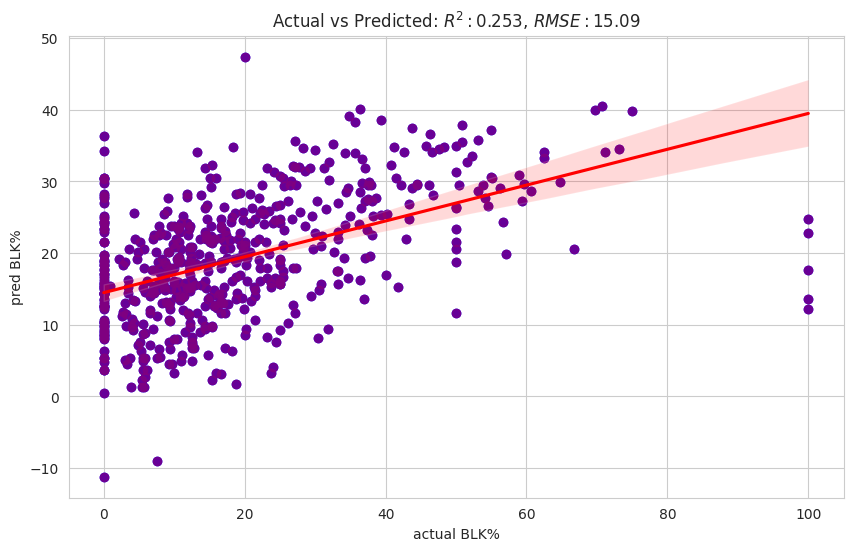

In [216]:
#goodness of fit of predicted vs actual
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, color='blue')
sns.regplot(x=y, y=y_pred, scatter_kws={"color": "purple"}, line_kws={"color": "red"})
plt.title(f'Actual vs Predicted: $R^2:{r2:.3f}$, $RMSE: {rmse:.2f}$')
plt.xlabel('actual BLK%')
plt.ylabel('pred BLK%')
plt.show()

In [217]:
from sklearn.linear_model import Lasso
# L1 version
# Create a linear regression model instance
lasso = Lasso(alpha=1.0)  # You can adjust alpha to see different results

# Fit the model
lasso.fit(X, y)

# Display the coefficients
print("Coefficients:", lasso.coef_)
print("Intercept:", lasso.intercept_)

# Use the model to make predictions
y_pred = lasso.predict(X)

Coefficients: [0.         0.88941969 0.08564319]
Intercept: -176.25902218098742


In [218]:
# Calculate MSE
mse = mean_squared_error(y, y_pred)
print("Mean Squared Error (MSE):", mse)

# Calculate RMSE
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)


# Calculate R-squared (R^2)
r2 = r2_score(y, y_pred)
print("R-squared (R^2):", r2)

Mean Squared Error (MSE): 227.74711616255252
Root Mean Squared Error (RMSE): 15.091292726686886
R-squared (R^2): 0.25311946904707794


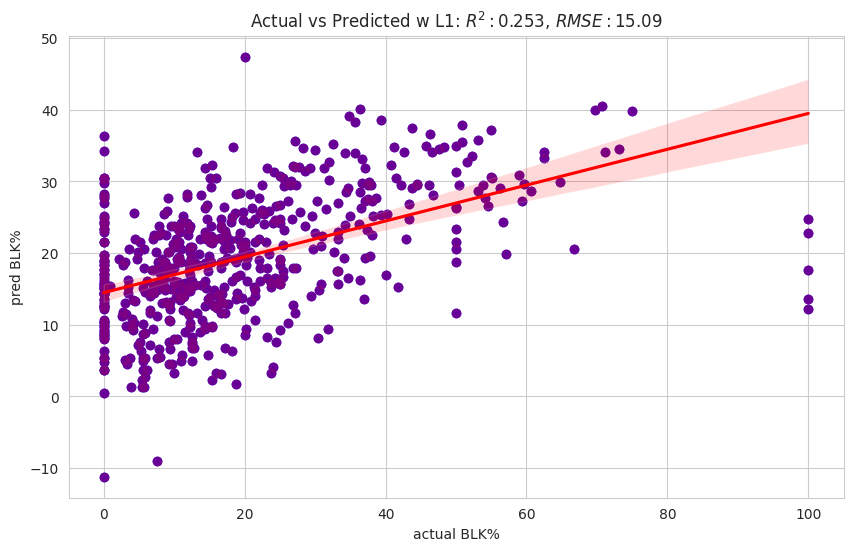

In [219]:
#goodness of fit of predicted vs actual
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, color='blue')
sns.regplot(x=y, y=y_pred, scatter_kws={"color": "purple"}, line_kws={"color": "red"})
plt.title(f'Actual vs Predicted w L1: $R^2:{r2:.3f}$, $RMSE: {rmse:.2f}$')
plt.xlabel('actual BLK%')
plt.ylabel('pred BLK%')
plt.show()

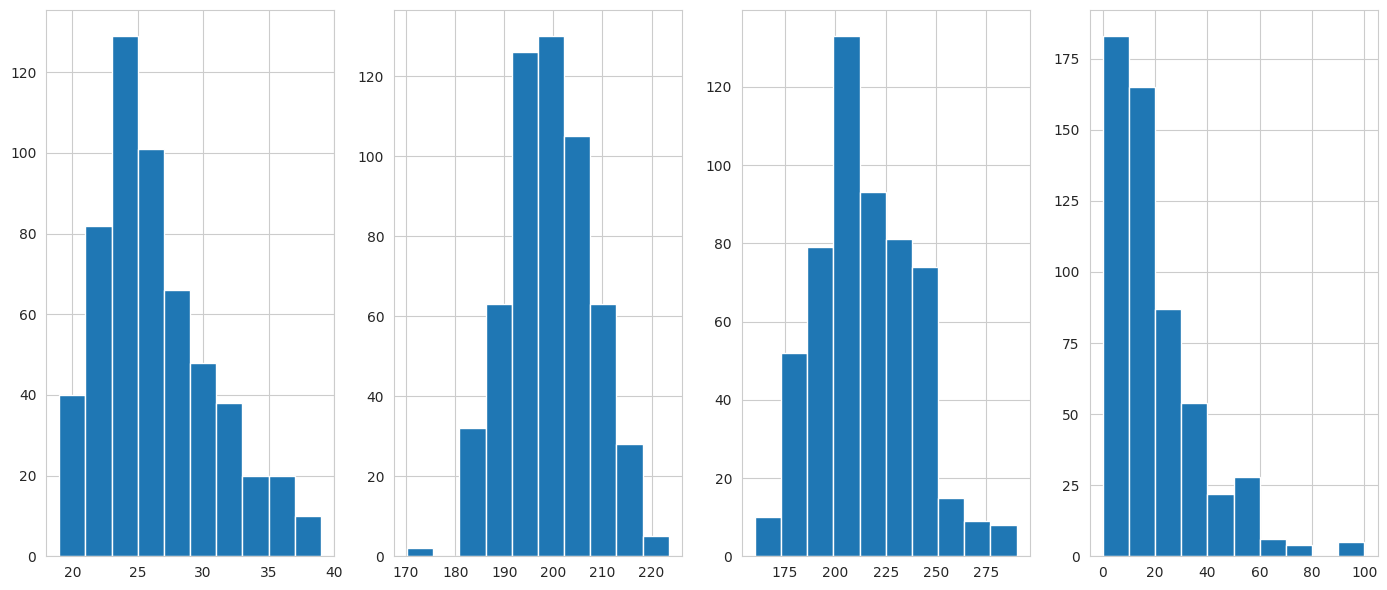

In [223]:
plt.figure(figsize=(14, 6))
# Plot for Column1 vs Column3
plt.subplot(1, 4, 1)  # 1 row, 2 columns, 1st subplot
def_stat_min['AGE'].hist()
plt.subplot(1, 4, 2)  # 1 row, 2 columns, 1st subplot
def_stat_min['HEIGHT'].hist()
plt.subplot(1, 4, 3)  # 1 row, 2 columns, 1st subplot
def_stat_min['WEIGHT'].hist()
plt.subplot(1, 4, 4)  # 1 row, 2 columns, 1st subplot
def_stat_min['BLK_PCT'].hist()

# Display the plots
plt.tight_layout()
plt.show()